In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation     
import sys

sys.path.append('/workspaces/Tugas_Grafik/')
from Potential import Potential

In [66]:
class MatrixMethod_V3:
    def __init__(self, potential_obj):
        self.potential = potential_obj
        self.x = potential_obj.parent.x
        self.dx = self.x[1] - self.x[0]
        self.V = potential_obj.get_potential()
        self.m = potential_obj.parent.m
        self.hbar = potential_obj.parent.h
        self.E = potential_obj.parent.E
        
        # Calculate k with proper complex components
        self.k = np.array([
            np.sqrt(2.0 * self.m * (self.E - V) + 0j) / self.hbar 
            for V in self.V
        ])

    def transfer_matrix(self, k1, k2, x):
        """Calculate transfer matrix between regions j and j+1"""
        # Avoid division by zero
        if abs(k1) < 1e-10:
            k1 = 1e-10 + 0j
        if abs(k2) < 1e-10:
            k2 = 1e-10 + 0j
            
        # Phase factors
        exp_plus = np.exp(1j * k1 * x)
        exp_minus = np.exp(-1j * k1 * x)
        
        # Transfer matrix elements
        t11 = 0.5 * (1 + k2/k1) * exp_plus
        t12 = 0.5 * (1 - k2/k1) * exp_minus
        t21 = 0.5 * (1 - k2/k1) * exp_plus
        t22 = 0.5 * (1 + k2/k1) * exp_minus
        
        return np.array([[t11, t12], [t21, t22]], dtype=complex)

    def calculate_transmission(self):
        """Calculate transmission using amplitude coefficients"""
        # Initialize amplitude coefficients
        # In last region: A_{n+1} = 1 (incident wave), B_{n+1} = 0 (no reflection)
        amplitudes = np.array([1.0, 0.0], dtype=complex)
        
        # Work backwards through regions
        for i in range(len(self.x)-2, -1, -1):
            k_current = self.k[i]
            k_next = self.k[i+1]
            
            if abs(k_current - k_next) > 1e-10:
                # Calculate transfer matrix
                T = self.transfer_matrix(k_current, k_next, self.x[i])
                
                # Update amplitudes
                amplitudes = T @ amplitudes
        
        # Calculate transmission coefficient
        # T = |t|^2 = |1/A_0|^2 * (k_final/k_initial)
        A_0 = amplitudes[0]
        
        if abs(A_0) < 1e-10:
            return 0.0
            
        t = 1.0 / A_0
        T = np.abs(t)**2 * (self.k[-1]/self.k[0]).real
        
        return np.clip(T.real, 0, 1)

    
    def plot_transmission_analysis(self, save_path='plots'):
        """Plot potential and wavevector analysis"""
        os.makedirs(save_path, exist_ok=True)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Plot potential and energy
        ax1.plot(self.x, self.V, 'b-', label='V(x)')
        ax1.axhline(y=self.potential.parent.E, color='r', linestyle='--', label='E')
        ax1.set_ylabel('Potential')
        ax1.set_title('Potential and Energy')
        ax1.legend()
        
        # Plot wavevector
        ax2.plot(self.x, np.real(self.k), 'g-', label='Re(k)')
        ax2.plot(self.x, np.imag(self.k), 'r--', label='Im(k)')
        ax2.set_ylabel('Wavevector k')
        ax2.set_xlabel('Position')
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, 'transmission_analysis.png'))
        plt.show()

    def calculate_wavefunction(self):
        """Calculate initial wavefunction with complex values"""
        psi_0 = np.exp(-0.5 * ((self.x - np.mean(self.x)) / (0.1 * np.ptp(self.x)))**2)
        return psi_0.astype(complex)  # Ensure complex dtype

    def time_evolution(self, psi_0, t):
        """Evolve wavefunction in time"""
        # Placeholder for actual time evolution calculation
        omega = self.E / self.hbar
        psi_t = psi_0 * np.exp(-1j * omega * t)
        return psi_t

    def animate_propagation(self, t_max=10, n_steps=100, save_path='animations'):
        """Animate wavefunction propagation with saving option"""
        os.makedirs(save_path, exist_ok=True)
        
        psi_0 = self.calculate_wavefunction()
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        line_real, = ax1.plot(self.x, np.real(psi_0), 'b-', label='Re(ψ)')
        line_imag, = ax1.plot(self.x, np.imag(psi_0), 'r--', label='Im(ψ)')
        line_prob, = ax2.plot(self.x, np.abs(psi_0)**2, 'g-', label='|ψ|^2')
        
        ax1.set_ylabel('Wavefunction')
        ax1.legend()
        ax2.set_ylabel('Probability Density')
        ax2.set_xlabel('Position')
        ax2.legend()
        
        def animate(frame):
            t = frame * t_max / n_steps
            psi_t = self.time_evolution(psi_0, t)
            
            line_real.set_data(self.x, np.real(psi_t))
            line_imag.set_data(self.x, np.imag(psi_t))
            line_prob.set_data(self.x, np.abs(psi_t)**2)
            
            return line_real, line_imag, line_prob
        
        anim = FuncAnimation(fig, animate, init_func=lambda: (line_real, line_imag, line_prob),
                           frames=n_steps, interval=50, blit=True)
        
        # Save animation
        try:
            # Try using FFmpeg first (better quality)
            writer = FFMpegWriter(fps=30, bitrate=2000)
            anim.save(os.path.join(save_path, 'wavefunction.mp4'), writer=writer)
        except Exception:
            # Fall back to GIF if FFmpeg is not available
            writer = PillowWriter(fps=30)
            anim.save(os.path.join(save_path, 'wavefunction.gif'), writer=writer)
            
        plt.tight_layout()
        plt.show()


Transmission coefficient: 1.000000


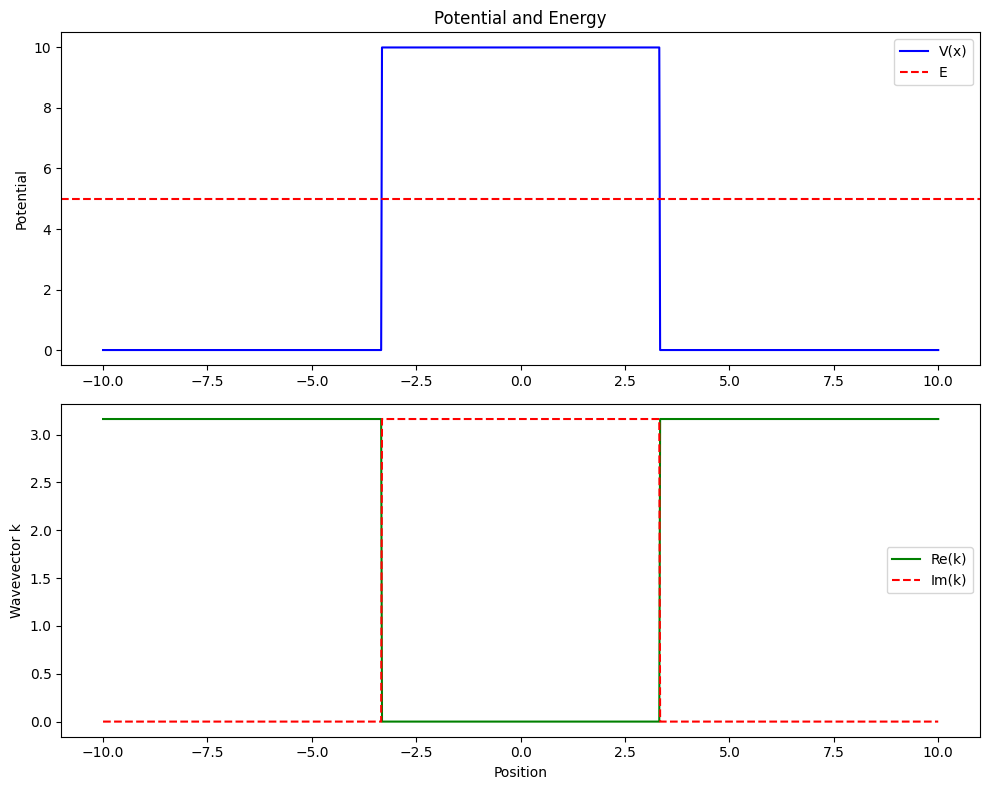

In [68]:
#ignore this block for review, just for testing
#Example usage  
pot = Potential(N=1000, a=10, E=5, m=1.0, h=1.0)
barrier = pot.PotentialBarrier(pot, V_max=10.0, V_min=0.0, width=1/3)

def compute_wavefunction_propagation(potential_obj):
    trans_calc = MatrixMethod_V3(potential_obj)
    trans_calc.animate_propagation()
    
def compute_transmission(potential_obj):
    trans_calc = MatrixMethod_V3(potential_obj)
    T = trans_calc.calculate_transmission()
    print(f"Transmission coefficient: {T:.6f}")
    
    # Save analysis plots
    trans_calc.plot_transmission_analysis()

if __name__ == '__main__':
    compute_transmission(barrier)
    #compute_wavefunction_propagation(barrier)

Transmission coefficient: 1.000000


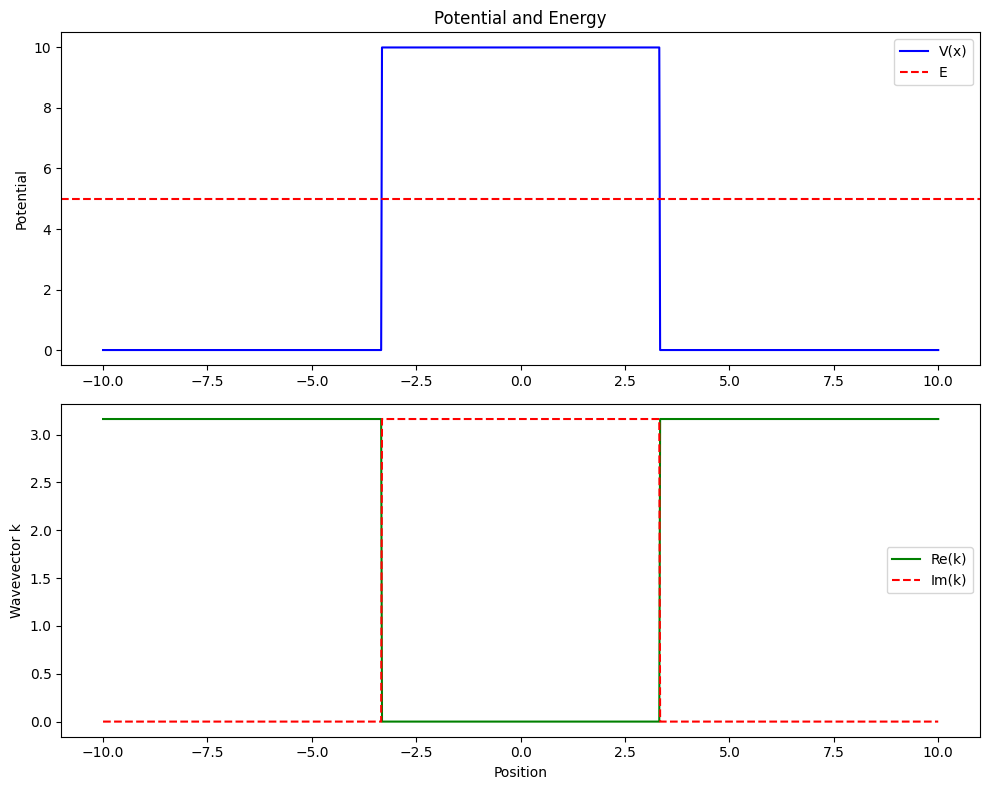

In [69]:
# Test E < V (tunneling)
pot1 = Potential(N=1000, a=10, E=5, m=1.0, h=1.0)
barrier1 = pot1.PotentialBarrier(pot1, V_max=10.0, V_min=0.0, width=1/3)
compute_transmission(barrier1)

In [9]:
class MatrixMethod_V3:
    def __init__(self, potential_obj):
        self.potential = potential_obj
        self.x = potential_obj.parent.x
        self.dx = self.x[1] - self.x[0]
        self.V = potential_obj.get_potential()
        self.m = potential_obj.parent.m
        self.hbar = potential_obj.parent.h
        self.E = potential_obj.parent.E
        self.h2m = 0.5  # ℏ²/2m factor

    def calculate_transmission(self):
        """Calculate transmission using amplitude method"""
        zi = 1j  # Complex unit
        
        # Initial conditions at rightmost point
        ap = .5 + 0.0j
        bp = 0.0 + 0.0j
        
        # Work backwards through potential
        for i in range(len(self.x)-2, -1, -1):
            x = self.x[i]
            xp = x + self.dx
            
            # Calculate k values using ec
            V = self.V[i]
            Vp = self.V[i+1]
            
            ec = (self.E - V) / self.h2m
            k = np.sqrt(ec + 0j)
            
            ec = (self.E - Vp) / self.h2m
            kp = np.sqrt(ec + 0j)
            
            # Update coefficients exactly as in example
            a = 0.5 * (ap * (1.0 + kp/k) * np.exp(zi * kp * x) + 
                       bp * (1.0 - kp/k) * np.exp(-zi * kp * x)) * np.exp(-zi * k * x)
            
            b = 0.5 * (ap * (1.0 - kp/k) * np.exp(zi * kp * x) + 
                       bp * (1.0 + kp/k) * np.exp(-zi * kp * x)) * np.exp(zi * k * x)
            
            # Update for next iteration
            ap = a
            bp = b
        
        # Calculate transmission coefficient
        if abs(a) < 1e-10:
            return 0.0
            
        T = np.abs(b/a)**2
        return T
        
pot = Potential(N=1000, a=10, E=7, m=1.0, h=1.0)
barrier = pot.PotentialBarrier(pot, V_max=10.0, V_min=0.0, width=1/3)
step_potential = pot.StepPotential(pot, V_max=10.0,V_min=0.0)
    
def compute_transmission(potential_obj):
    trans_calc = MatrixMethod_V3(potential_obj)
    T = trans_calc.calculate_transmission()
    print(f"Transmission coefficient: {T:.6f}")

if __name__ == '__main__':
    compute_transmission(barrier)

Transmission coefficient: 1.000000


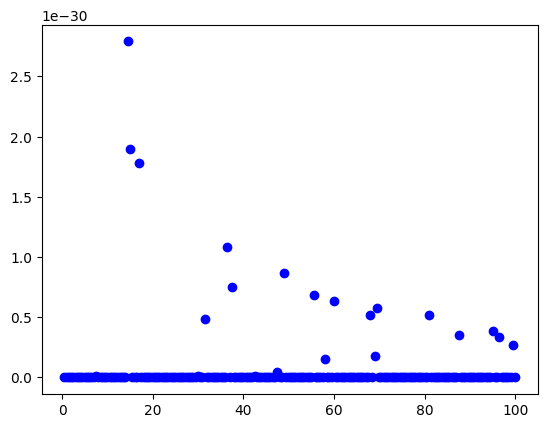

In [3]:
import numpy as np

# Constants and parameters
zi = 1j                           # Complex unit in Python
n = 5000                          # Number of spatial points
n_e = 200                         # Number of energy levels
xl = -15.0                        # Lower bound of x
xu = 15.0                         # Upper bound of x
h2m = 0.5                         # Constant factor

# Step size in x direction
h = (xu - xl) / (n + 1)

# Define the potential function (replace with actual potential)
def potential(x):
    # Placeholder: zero potential everywhere
    return 0.0 + 0.0j

# Loop over different energy levels
for i in range(1, n_e + 1):
    V = potential(xu)               # Potential at the upper bound of x
    E = 0.5 * i                     # Energy level
    ec = (E - V) / h2m
    k0 = np.sqrt(ec)                # Initial wavevector k0

    # Initial conditions for coefficients ap and bp
    ap = 1.0 + 0.0j                 # Complex number (1.0, 0.0)
    bp = 0.0 + 0.0j                 # Complex number (0.0, 0.0)

    # Loop over spatial points from n to 0 (reverse loop)
    for j in range(n, -1, -1):
        x = xl + j * h              # Current position
        V = potential(x)            # Potential at x
        xp = x + h                  # Next position
        Vp = potential(xp)          # Potential at xp
        
        # Calculate k and kp based on the potential at x and xp
        ec = (E - V) / h2m
        k = np.sqrt(ec)
        
        ec = (E - Vp) / h2m
        kp = np.sqrt(ec)

        # Update coefficients a and b
        a = 0.5 * (ap * (1.0 + kp / k) * np.exp(zi * kp * x) +
                   bp * (1.0 - kp / k) * np.exp(-zi * kp * x)) * np.exp(-zi * k * x)
        
        b = 0.5 * (ap * (1.0 - kp / k) * np.exp(zi * kp * x) +
                   bp * (1.0 + kp / k) * np.exp(-zi * kp * x)) * np.exp(zi * k * x)
        
        # Update previous coefficients for the next iteration
        ap = a
        bp = b

    # Calculate the transmission coefficient T = |b / a|^2 and print it for this energy
    transmission = abs(b / a)**2
    plt.plot(E, transmission, 'bo')
